In [2]:
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.preprocessing import MaxAbsScaler,RobustScaler
import warnings;warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv('train.csv',dtype = {"time":str})
df_test = pd.read_csv('test.csv',dtype = {"time":str})


#reset_index 有index欄位
train_test =pd.concat([df_train, df_test],sort=True).reset_index()

print(train_test.count())
print(train_test.head())
print(train_test.tail())
train_test_processed=pd.DataFrame()
train_test_processedPlt=pd.DataFrame()

index            5000000
open_channels    4000000
signal           5000000
time             5000000
dtype: int64
   index  open_channels  signal    time
0      0            0.0 -2.7600  0.0001
1      1            0.0 -2.8557  0.0002
2      2            0.0 -2.4074  0.0003
3      3            0.0 -3.1404  0.0004
4      4            0.0 -3.1525  0.0005
          index  open_channels  signal      time
4999995  999995            NaN  2.1378  249.9996
4999996  999996            NaN -0.1218  249.9997
4999997  999997            NaN  1.8639  249.9998
4999998  999998            NaN  3.6897  249.9999
4999999  999999            NaN  2.8510  250.0000


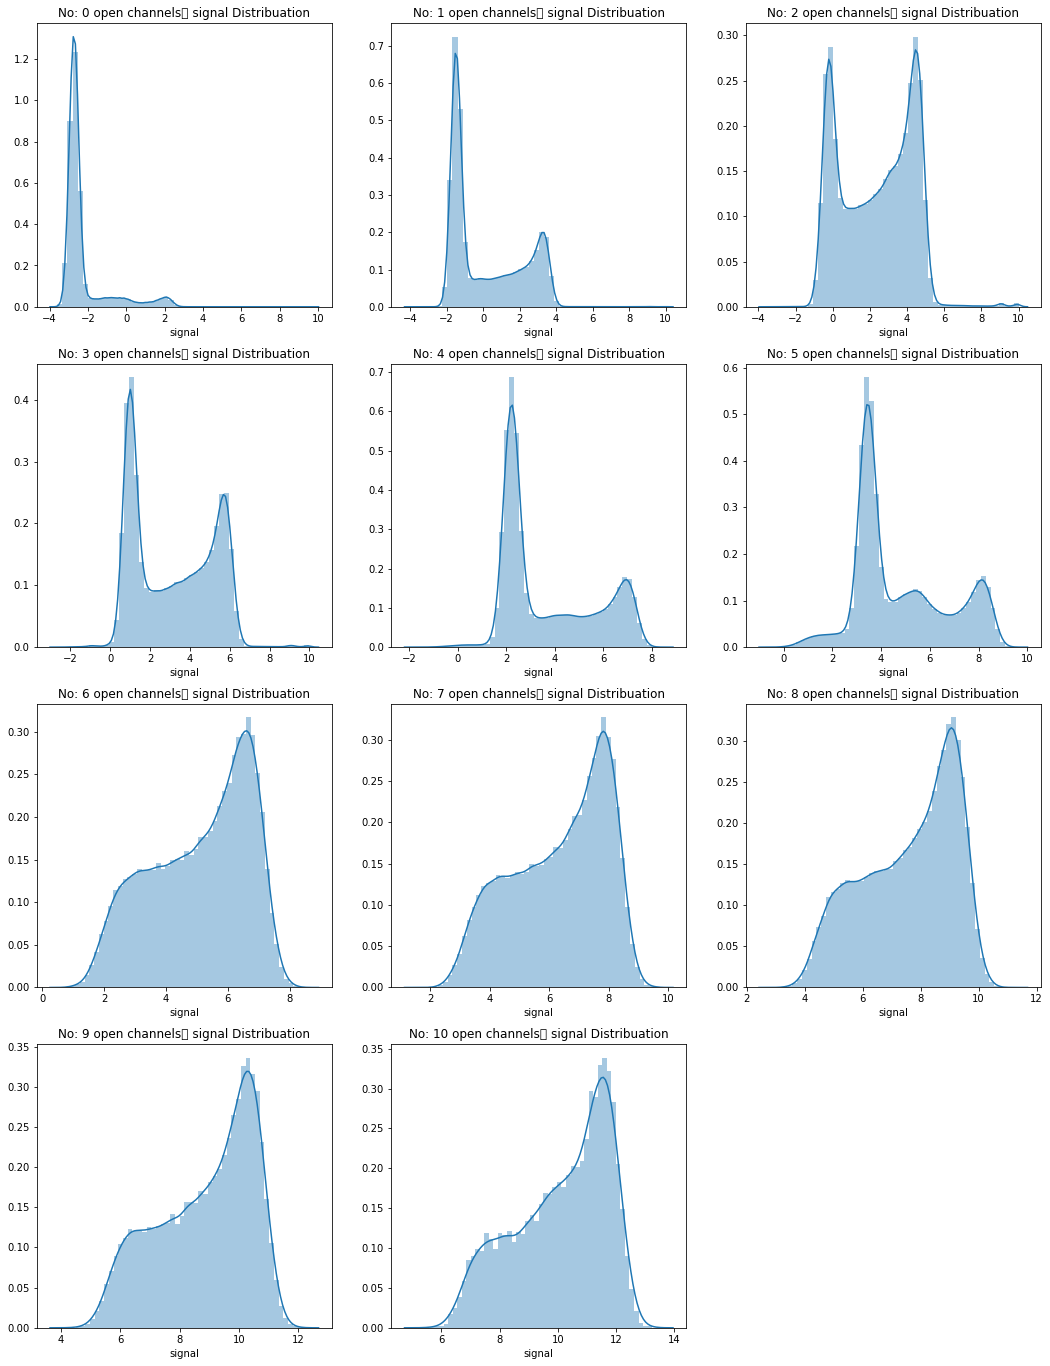

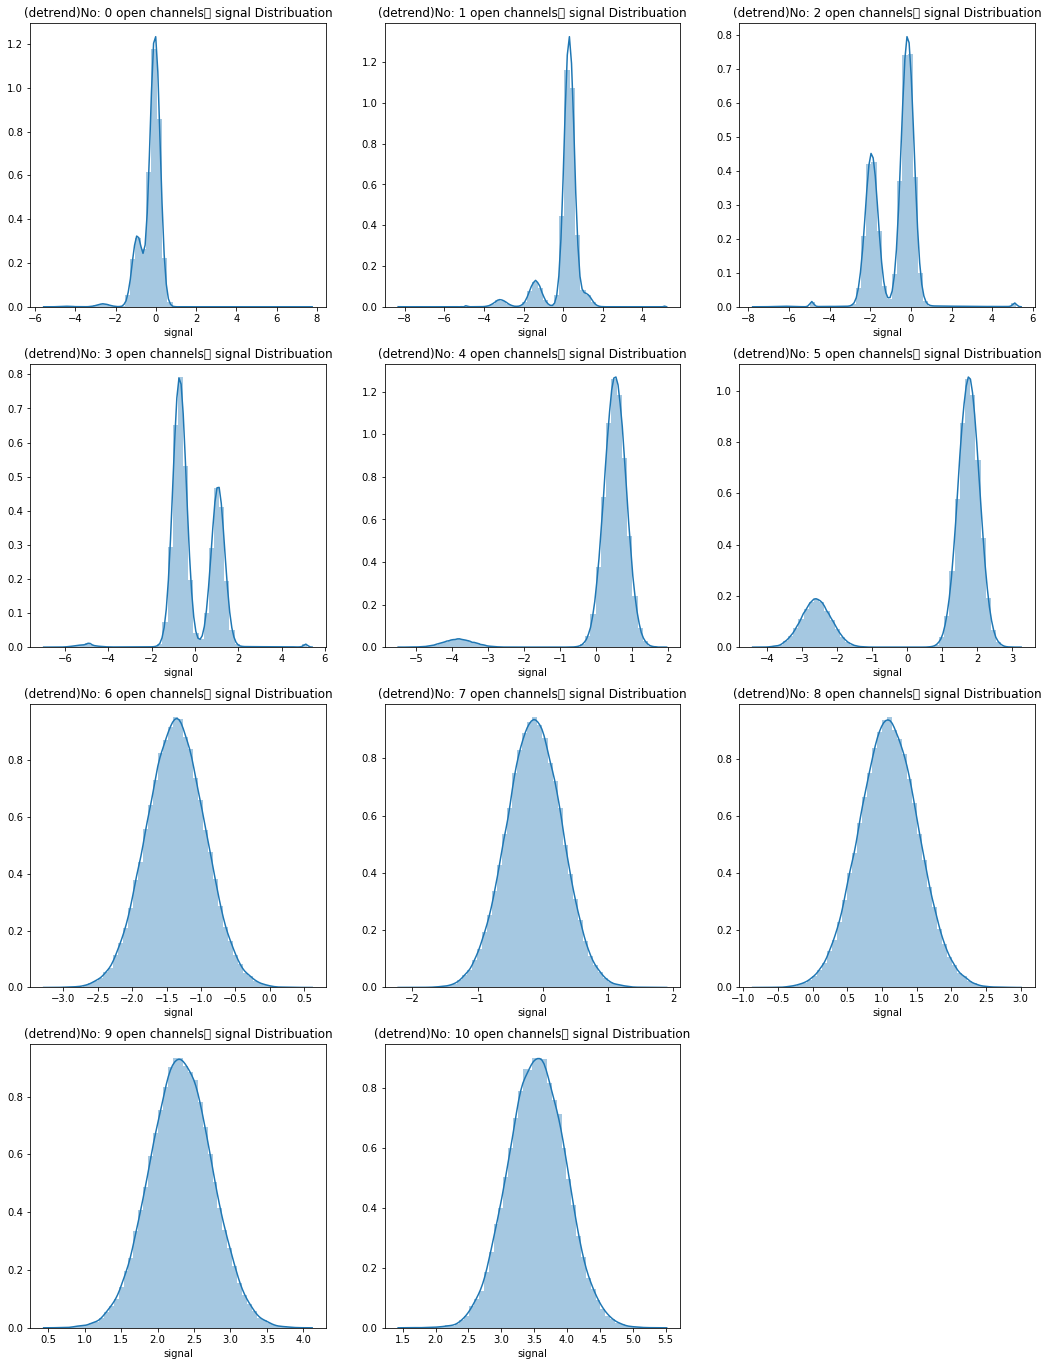

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

for i in range(len(train_test)//50000):
    batch =train_test.loc[i * 50000:((i + 1) * 50000) - 1]

    #去除線性趨勢
    batch['signal'] = signal.detrend(batch['signal'])
    train_test_processedPlt=pd.concat([train_test_processedPlt, batch],sort=False).reset_index(drop=True)


idx = 0
plt.figure(figsize=(18,24))
#df_train.groupby('open_channels') 表示有11個class需要作答
for i, d in df_train.groupby('open_channels'):
    plt.subplot(4,3,idx+1)
    sns.distplot(d['signal'], bins=50)
    plt.title('No: %d open channels的 signal Distribuation' % i)
    idx += 1
    

idx = 0
plt.figure(figsize=(18,24))
for i, d in train_test_processedPlt.groupby('open_channels'):
    plt.subplot(4,3,idx+1)
    sns.distplot(d['signal'], bins=50)
    plt.title('(detrend)No: %d open channels的 signal Distribuation' % i)
    idx += 1

## 參考 https://www.kaggle.com/mikalaichaly/compare-different-scalers-on-data-with-outliers#RobustScaler

In [5]:
for i in range(len(train_test)//50000):
    batch =train_test.loc[i * 50000:((i + 1) * 50000) - 1]

    batch['signal'] = signal.detrend(batch['signal'])

    #愈小愈明顯,愈大也愈強,某種程度把雜訊給磨平
    batch['roll_min'] = batch['signal'].rolling(window=5, min_periods=1).min()
    batch['roll_max'] = batch['signal'].rolling(window=5, min_periods=1).max()
    
    #MaxAbsScaler，曲線還在，降在[0,1]之間，但很容易受到離群值的影響
    batch['signal_scale_m'] = MaxAbsScaler().fit_transform(batch['signal'].values.reshape(-1,1)).reshape(-1).mean()
    #RobustScaler，曲線還在，根據統計的百分比方式作呈現，而且比較不會有離群值的影響
    batch['signal_scale_r'] = RobustScaler().fit_transform(batch['signal'].values.reshape(-1,1)).reshape(-1).mean()
    train_test_processed=pd.concat([train_test_processed, batch],sort=False).reset_index(drop=True)
y_train = df_train['open_channels']
X_train=train_test_processed[0:len(df_train)][['signal','roll_min','roll_max','signal_scale_m','signal_scale_r']]
X_test=train_test_processed[len(df_train):][['signal','roll_min','roll_max','signal_scale_m','signal_scale_r']]

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
import sklearn.metrics as metrics
MyX_train, MyX_test, Myy_train, Myy_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

cls = RandomForestClassifier(n_estimators=200, n_jobs= -1)

cls.fit(MyX_train, Myy_train)
# 預測值
y_pred=cls.predict(MyX_test)
# 真實值
y_true= Myy_test


# 計算精度
print("Accuracy : %.4g" % metrics.accuracy_score(y_true, y_pred))


Accuracy : 0.9692


In [7]:
test_pred = cls.predict(X_test)
output = pd.DataFrame({'time': df_test['time'], 'open_channels': test_pred})
output.to_csv('RandomForestV1_5_2.csv', index=False,float_format='%.4f')

In [4]:
s = [1,2,3,5,6,10,12,14,12,30]
pd.Series(s).rolling(window=3).min()

0     NaN
1     NaN
2     1.0
3     2.0
4     3.0
5     5.0
6     6.0
7    10.0
8    12.0
9    12.0
dtype: float64